In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time

mingw_bin = "C:/msys64/mingw64/bin"
os.add_dll_directory(mingw_bin)
import ctypes
lin = ctypes.cdll.LoadLibrary("./cmake-build-debug/liblinear_model.dll")

lin.create_linear_model.argtypes = [ctypes.c_int32]
lin.create_linear_model.restype = ctypes.c_void_p

lin.predict_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_linear_model.restype = ctypes.c_float

lin.release_linear_model.argtypes = [ctypes.c_void_p]
lin.release_linear_model.restype = None

lin.train_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float), ctypes.c_int32, ctypes.c_float, ctypes.c_int32]
lin.train_linear_model.restype = None

lin.create_ovo_classifier.argtypes = [ctypes.c_int32]
lin.create_ovo_classifier.restype = ctypes.c_void_p

lin.train_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_int32), ctypes.c_int32, ctypes.c_int32, ctypes.c_float]
lin.train_ovo_classifier.restype = None

lin.predict_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_ovo_classifier.restype = ctypes.c_int32

lin.release_ovo_classifier.argtypes = [ctypes.c_void_p]
lin.release_ovo_classifier.restype = None


mlp = ctypes.cdll.LoadLibrary("./cmake-build-debug/libmlp.dll") 

mlp.create_mlp_model.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_int]
mlp.create_mlp_model.restype = ctypes.c_void_p

mlp.train_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_float,
    ctypes.c_int,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int
]
mlp.predict_mlp_model.restype = ctypes.POINTER(ctypes.c_float)

mlp.predict_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_bool
]

mlp.release_mlp_model.argtypes = [ctypes.c_void_p]

mlp.get_confusion_matrix.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_int32)]
mlp.get_confusion_matrix.restype = None

mlp.evaluate_confusion_matrix.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_bool 
]
mlp.evaluate_confusion_matrix.restype = None

mlp.save_mlp_model.argtypes = [ctypes.c_void_p, ctypes.c_char_p]

mlp.load_mlp_model.argtypes = [ctypes.c_char_p]
mlp.load_mlp_model.restype = ctypes.c_void_p


LOG_FUNC_TYPE = ctypes.CFUNCTYPE(None, ctypes.c_char_p)

@LOG_FUNC_TYPE
def logger_callback(msg):
    print(msg.decode())

In [2]:
classnames_array = ['buffalo', 'elephant', 'zebre']
size = 32

### Changement de résolution des images du dataset:

In [5]:
for classname in classnames_array:
    folder_path = 'images/' + classname 
    for filename in os.listdir(folder_path):
        img = Image.open(folder_path + '/' + filename).convert("RGB")
        img = img.resize(size=(size,size))
        new_folder = './images' + str(size) + '/' + classname
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)
        img.save(new_folder + '/' + filename, format="JPEG")

### Organisation du Dataset pour l'entrainement

In [4]:
data = []
folder_path = './images32/'
for classname in os.listdir(folder_path):  
    for filename in os.listdir(folder_path + classname):
        img = Image.open(folder_path + classname + '/' + filename)
        
        # Trouver l'index correct dans classnames_array
        index = classnames_array.index(classname)  
        
        one_hot = np.zeros(len(classnames_array), dtype=np.float32)
        one_hot[index] = 1.0
        
        img_array = (np.array(img) / 255.0) - 1.0
        data.append([one_hot, img_array])

data = np.array(data, dtype=object)




### Test avec MLP

Epoch 1: acc = 31.22%, loss = 2.0417
Epoch 2: acc = 31.65%, loss = 2.0021
Epoch 3: acc = 29.11%, loss = 1.9657
Epoch 4: acc = 29.96%, loss = 1.9206
Epoch 5: acc = 30.38%, loss = 1.8835
Epoch 6: acc = 32.49%, loss = 1.8288
Epoch 7: acc = 29.96%, loss = 1.7775
Epoch 8: acc = 30.80%, loss = 1.7790
Epoch 9: acc = 30.80%, loss = 1.7439
Epoch 10: acc = 33.33%, loss = 1.6989
Epoch 11: acc = 31.65%, loss = 1.6952
Epoch 12: acc = 32.49%, loss = 1.6994
Epoch 13: acc = 30.38%, loss = 1.6888
Epoch 14: acc = 32.49%, loss = 1.6801
Epoch 15: acc = 31.65%, loss = 1.6739
Epoch 16: acc = 31.65%, loss = 1.6827
Epoch 17: acc = 30.80%, loss = 1.6794
Epoch 18: acc = 32.07%, loss = 1.6545
Epoch 19: acc = 32.07%, loss = 1.6517
Epoch 20: acc = 32.07%, loss = 1.6400
Epoch 21: acc = 32.07%, loss = 1.6332
Epoch 22: acc = 32.49%, loss = 1.6260
Epoch 23: acc = 32.91%, loss = 1.5893
Epoch 24: acc = 31.65%, loss = 1.5947
Epoch 25: acc = 33.76%, loss = 1.5465
Epoch 26: acc = 32.91%, loss = 1.5248
Epoch 27: acc = 34.60

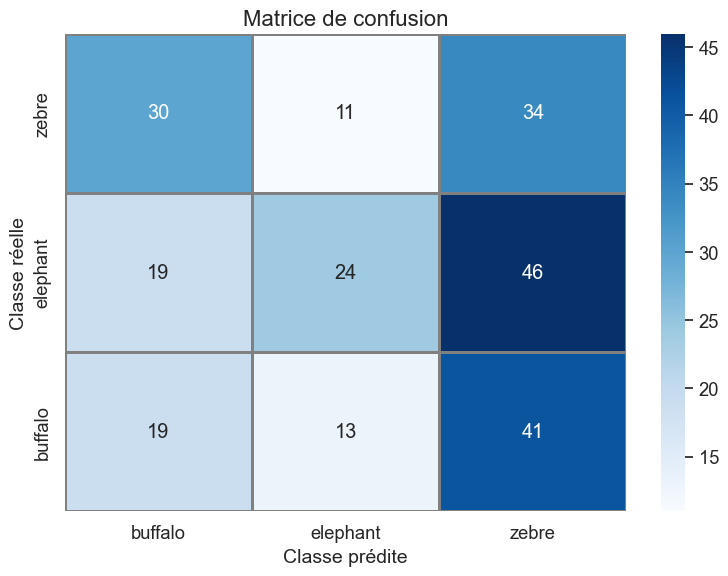

In [5]:
layer_sizes = [size*size*3, 64, 32, len(classnames_array)]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1)
mlp.set_logger(logger_callback)

np.random.shuffle(data)
split_index = int(len(data) * 0.8)
data_train = data[:split_index]
data_test = data[split_index:]
X_train = np.array([item[1] for item in data_train], dtype=np.float32)
Y_train = np.array([item[0] for item in data_train], dtype=np.float32)
X_test = np.array([item[1] for item in data_test], dtype=np.float32)
Y_test = np.array([item[0] for item in data_test], dtype=np.float32)

X_train_reshaped = X_train.reshape((X_train.shape[0], -1))  # (N, 3072)
X_train_c = X_train_reshaped.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_train_c = Y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))  # (N, 3072)
X_test_c = X_test_reshaped.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_test_c = Y_test.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 100
learning_rate = 0.01
batch_size = 32

with open("log.csv", "w") as csvfile:
        csvfile.truncate()
        csvfile.write("epoch,accuracy,loss\n")
time.sleep(0.2)

mlp.train_mlp_model(model, X_train_c, Y_train_c, len(data_train), epochs, learning_rate, batch_size, True, X_test_c, Y_test_c, len(data_test))

output_dim = len(classnames_array)
matrix = (ctypes.c_int * (output_dim * output_dim))()
mlp.evaluate_confusion_matrix(model, X_test_c, Y_test_c, len(data_test), True)
mlp.get_confusion_matrix(model, matrix)


# Conversion en numpy array
confusion_np = np.ctypeslib.as_array(matrix).reshape((output_dim, output_dim))
print(confusion_np)
import seaborn as sns

# Matrice de confusion fournie

classnames_array = ['buffalo', 'elephant', 'zebre']

# Affichage avec Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion_np, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classnames_array, yticklabels=classnames_array[::-1],
                 linewidths=1, linecolor='gray', cbar=True)

plt.title("Matrice de confusion", fontsize=16)
plt.xlabel("Classe prédite", fontsize=14)
plt.ylabel("Classe réelle", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
mlp.release_mlp_model(model)

1

In [6]:
mlp.save_mlp_model(model, b"mlp_trained.bin")

1254005656

In [4]:
model_loaded = mlp.load_mlp_model(b"mlp_trained.bin")

In [ ]:
img = Image.open('C:/Users/lgrdp/Downloads/images (10).jpeg').convert("RGB")
img = img.resize(size=(32,32))
img_data = np.array(img) / 255.0

output_array = mlp.predict_mlp_model(model_loaded, img_data.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
output_array = ctypes.cast(output_array, ctypes.POINTER(ctypes.c_float * len(classnames_array))).contents
output = list(output_array)
class_index = 0
for i in range(len(output)):
    if output[i] == max(output):
        class_index = i
print('predicted class : ' + classnames_array[class_index])
print(output)


predicted class : zebre
[0.41036975383758545, 0.0005949240876361728, 0.5890353322029114]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))
Y_train_cat = to_categorical(Y_train, num_classes=len(classnames_array))
Y_test_cat = to_categorical(Y_test, num_classes=len(classnames_array))

def ensure_categorical(Y, num_classes):
    Y = np.array(Y)
    if len(Y.shape) == 1:
        return to_categorical(Y, num_classes)
    elif Y.shape[1] == num_classes:
        return Y 
    else:
        raise ValueError(f"Format inattendu pour Y (shape: {Y.shape})")

Y_train_cat = ensure_categorical(Y_train, len(classnames_array))
Y_test_cat = ensure_categorical(Y_test, len(classnames_array))

model = Sequential([
    Input(shape=(X_train_reshaped.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(classnames_array), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_reshaped, Y_train_cat,
          epochs=200,
          batch_size=32,
          validation_data=(X_test_reshaped, Y_test_cat),
          verbose=2)

predictions = model.predict(X_test_reshaped)
pred_labels = np.argmax(predictions, axis=1)
acc = accuracy_score(Y_test, pred_labels)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

Epoch 1/200
30/30 - 1s - 32ms/step - accuracy: 0.3294 - loss: 2.3289 - val_accuracy: 0.3207 - val_loss: 1.2150
Epoch 2/200
30/30 - 0s - 5ms/step - accuracy: 0.4068 - loss: 1.1156 - val_accuracy: 0.5612 - val_loss: 0.9969
Epoch 3/200
30/30 - 0s - 5ms/step - accuracy: 0.4449 - loss: 1.0289 - val_accuracy: 0.5105 - val_loss: 0.9973
Epoch 4/200
30/30 - 0s - 5ms/step - accuracy: 0.4703 - loss: 1.0187 - val_accuracy: 0.5865 - val_loss: 0.9237
Epoch 5/200
30/30 - 0s - 5ms/step - accuracy: 0.5148 - loss: 0.9672 - val_accuracy: 0.5612 - val_loss: 0.8951
Epoch 6/200
30/30 - 0s - 5ms/step - accuracy: 0.5212 - loss: 0.9647 - val_accuracy: 0.5696 - val_loss: 0.9445
Epoch 7/200
30/30 - 0s - 5ms/step - accuracy: 0.5572 - loss: 0.9203 - val_accuracy: 0.5401 - val_loss: 0.9073
Epoch 8/200
30/30 - 0s - 5ms/step - accuracy: 0.5466 - loss: 0.9039 - val_accuracy: 0.6118 - val_loss: 0.8593
Epoch 9/200
30/30 - 0s - 5ms/step - accuracy: 0.5847 - loss: 0.8632 - val_accuracy: 0.5781 - val_loss: 0.8501
Epoch 10/

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets